In [62]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [63]:
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print('Error: Could not load image.')
        return None, None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image, gray

In [64]:
dataset_dir = 'images'
images = []
labels = []
for root, dirs, files in os.walk(dataset_dir):
    if len(files) == 0:
        continue
    for f in files:
        _, image = load_image(os.path.join(root, f))
        if image is None:
            continue
        images.append(image)
        labels.append(root.split('/')[-1])

In [65]:
len(images)

70

In [66]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [67]:
def detect_faces(image_gray, scale_factor=1.1, min_neighbors=5,min_size=(30, 30)):
    faces = face_cascade.detectMultiScale(
        image_gray,
        scaleFactor=scale_factor,
        minNeighbors=min_neighbors,
        minSize=min_size
    )
    return faces

In [68]:
detect_faces(images[0])

array([[ 65,  68, 118, 118]], dtype=int32)

In [69]:
def crop_faces(image_gray, faces, return_all=False):
    cropped_faces = []
    selected_faces = []
    if len(faces) > 0:
        if return_all:
            for x, y, w, h in faces:
                selected_faces.append((x, y, w, h))
                cropped_faces.append(image_gray[y:y+h, x:x+w])
        else:
            x, y, w, h = max(faces, key=lambda rect: rect[2] * rect[3])
            selected_faces.append((x, y, w, h))
            cropped_faces.append(image_gray[y:y+h, x:x+w])
    return cropped_faces, selected_faces

In [70]:
face_size = (128, 128)
def resize_and_flatten(face):
    face_resized = cv2.resize(face, face_size)
    face_flattened = face_resized.flatten()
    return face_flattened

In [71]:
X = []
y = []
for image, label in zip(images, labels):
    faces = detect_faces(image)
    cropped_faces, _ = crop_faces(image, faces)
    if len(cropped_faces) > 0:
        face_flattened = resize_and_flatten(cropped_faces[0])
        X.append(face_flattened)
        y.append(label)
X = np.array(X)
y = np.array(y)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=177, stratify=y)

In [73]:
from sklearn.base import BaseEstimator, TransformerMixin
class MeanCentering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.mean_face = np.mean(X, axis=0)
        return self
    def transform(self, X):
        return X - self.mean_face

In [74]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
pipe = Pipeline([
    ('centering', MeanCentering()),
    ('pca', PCA(svd_solver='randomized', whiten=True,
    random_state=177)),
    ('svc', SVC(kernel='linear', random_state=177))
])

In [75]:
from sklearn.metrics import classification_report
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

         Darryl       0.50      0.67      0.57         3
  George_W_Bush       0.00      0.00      0.00         3
            Kim       1.00      1.00      1.00         3
           Kwok       0.00      0.00      0.00         3
     Laura_Bush       0.50      1.00      0.67         3
Serena_Williams       0.75      1.00      0.86         3
 Vladimir_Putin       0.50      0.33      0.40         3

       accuracy                           0.57        21
      macro avg       0.46      0.57      0.50        21
   weighted avg       0.46      0.57      0.50        21



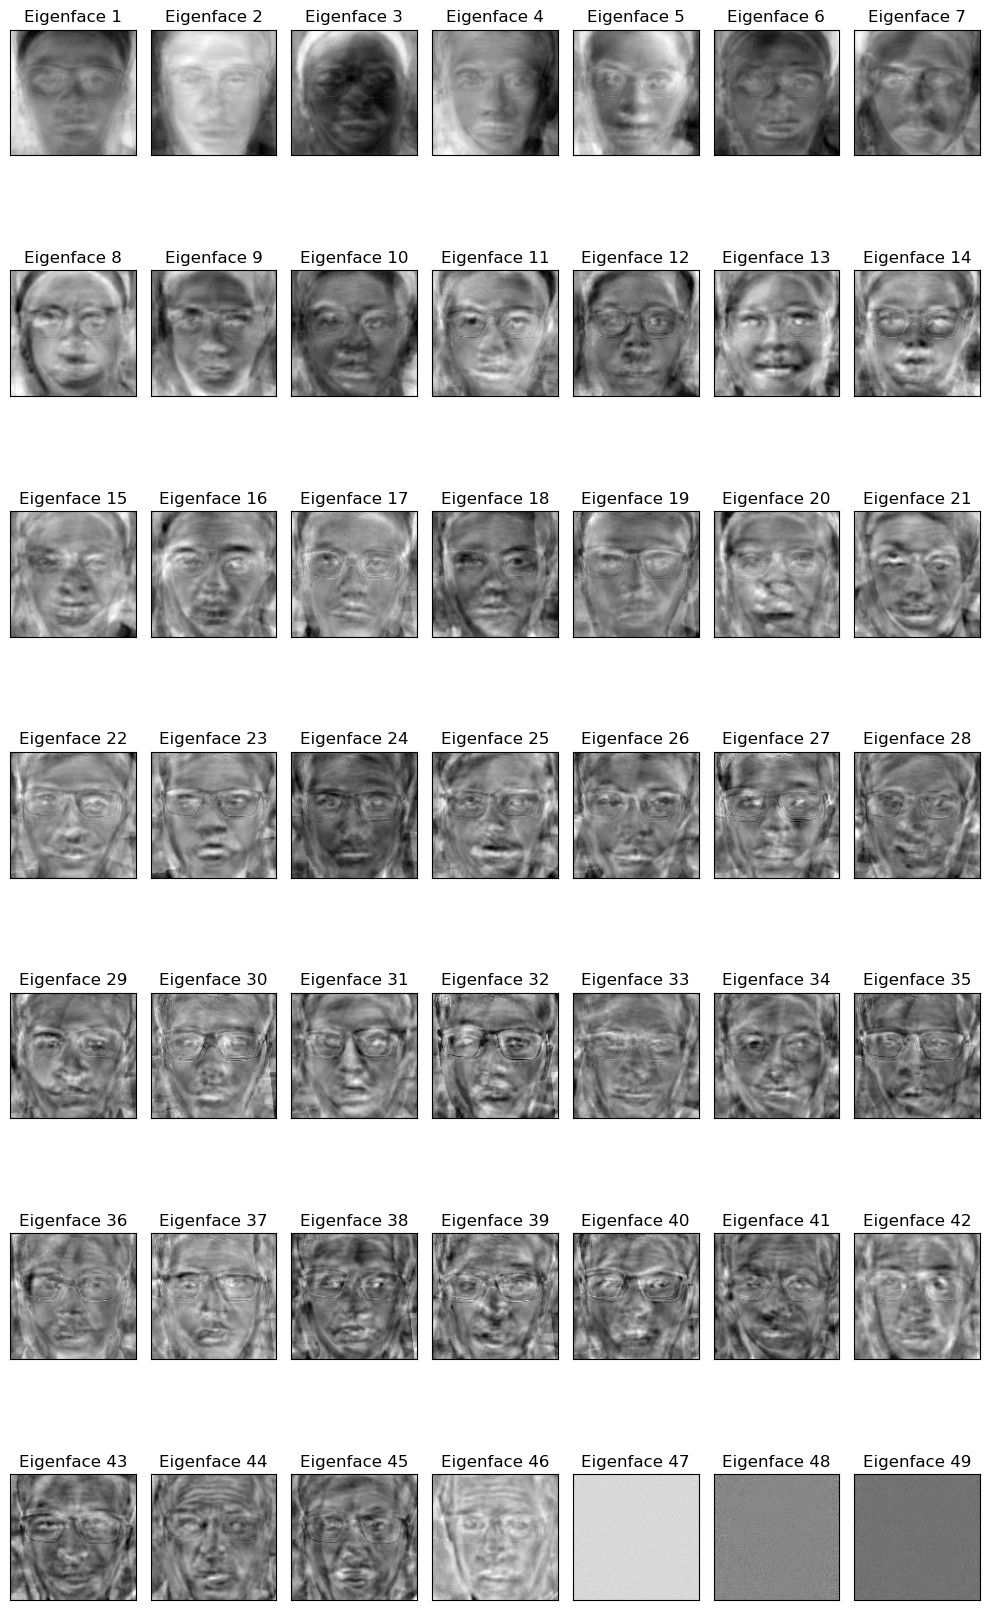

In [76]:
n_components = len(pipe[1].components_)
ncol = 7
nrow = (n_components + ncol - 1) // ncol
fig, axes = plt.subplots(nrow, ncol, figsize=(10, 2.5*nrow),
subplot_kw={'xticks':[], 'yticks':[]})
eigenfaces = pipe[1].components_.reshape((n_components,
X_train.shape[1]))
for i, ax in enumerate(axes.flat):
    ax.imshow(eigenfaces[i].reshape(face_size), cmap='gray')
    ax.set_title(f'Eigenface {i+1}')
plt.tight_layout()

In [77]:
import pickle
with open('eigenface_pipeline.pkl', 'wb') as f:
    pickle.dump(pipe, f)

In [78]:
def get_eigenface_score(X):
    X_pca = pipe[:2].transform(X)
    eigenface_scores = np.max(pipe[2].decision_function(X_pca), axis=1)
    return eigenface_scores


In [79]:
def eigenface_prediction(image_gray):
    faces = detect_faces(image_gray)
    cropped_faces, selected_faces = crop_faces(image_gray, faces)

    if len(cropped_faces) == 0:
        return 'No face detected.'

    X_face = []
    for face in cropped_faces:
        face_flattened = resize_and_flatten(face)
        X_face.append(face_flattened)

    X_face = np.array(X_face)
    labels = pipe.predict(X_face)
    scores = get_eigenface_score(X_face)

    return scores, labels, selected_faces

In [80]:
def draw_text(image, label, score,
              font=cv2.FONT_HERSHEY_SIMPLEX,
              pos=(0, 0),
              font_scale=0.6,
              font_thickness=2,
              text_color=(0, 0, 0),
              text_color_bg=(0, 255, 0)
    ):
    x, y = pos
    score_text = f'Score: {score:.2f}'
    (w1, h1), _ = cv2.getTextSize(score_text, font, font_scale,
                                    font_thickness)
    (w2, h2), _ = cv2.getTextSize(label, font, font_scale,
                                    font_thickness)
    cv2.rectangle(image, (x, y-h1-h2-25), (x + max(w1, w2)+20, y),
                  text_color_bg, -1)
    cv2.putText(image, label, (x+10, y-10), font, font_scale,
                text_color, font_thickness)
    cv2.putText(image, score_text, (x+10, y-h2-15), font, font_scale,
                text_color, font_thickness)

# This is how we draw the bounding box for each detected face
def draw_result(image, scores, labels, coords):
    result_image = image.copy()
    for (x, y, w, h), label, score in zip(coords, labels, scores):
        cv2.rectangle(result_image, (x, y), (x + w, y + h), (0, 255, 0),
                      2)
        draw_text(result_image, label, score, pos=(x, y))
    return result_image

In [81]:
img = cv2.imread('/home/darryl-chandra/Documents/20032005/images/Vladimir_Putin/10.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
eigenface_prediction(gray)[1][0]

'Vladimir_Putin'

In [82]:
import pickle
import uuid
with open('eigenface_pipeline.pkl', 'rb') as f:
    pipe = pickle.load(f)
cam = cv2.VideoCapture(0)

while True: #The stopping criterion is at the buttom: cv2.waitkey
    ret, frame = cam.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)    
    result = eigenface_prediction(gray)
    if result=="No face detected.":
        display_frame = frame
    else:
        scores, labels, coords = result
        display_frame = draw_result(frame, scores, labels, coords)
        random_name = f"documentation/{uuid.uuid4().hex[:8]}.jpg"
        cv2.imwrite(random_name, display_frame)
    cv2.imshow('Real-time Eigenface Recognition', display_frame)
    

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the capture and writer objects
cam.release()
cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x2a785620) is not the object's thread (0x2c20ee20).
Cannot move to target thread (0x2a785620)

QObject::moveToThread: Current thread (0x2a785620) is not the object's thread (0x2c20ee20).
Cannot move to target thread (0x2a785620)

QObject::moveToThread: Current thread (0x2a785620) is not the object's thread (0x2c20ee20).
Cannot move to target thread (0x2a785620)

QObject::moveToThread: Current thread (0x2a785620) is not the object's thread (0x2c20ee20).
Cannot move to target thread (0x2a785620)

QObject::moveToThread: Current thread (0x2a785620) is not the object's thread (0x2c20ee20).
Cannot move to target thread (0x2a785620)

QObject::moveToThread: Current thread (0x2a785620) is not the object's thread (0x2c20ee20).
Cannot move to target thread (0x2a785620)

QObject::moveToThread: Current thread (0x2a785620) is not the object's thread (0x2c20ee20).
Cannot move to target thread (0x2a785620)

QObject::moveToThread: Current thread (0x2a785620) is n